In [1]:
#importing the required packages
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [45]:
#reading all the required input files
data2 = pd.read_csv('Dataset/courses.csv')

In [2]:
#reading the merged file
df = pd.read_parquet('merged_parquet',engine='fastparquet')

In [3]:
df.shape

(8324303, 21)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8324303 entries, 0 to 8324302
Data columns (total 21 columns):
 #   Column                Dtype  
---  ------                -----  
 0   code_module           object 
 1   code_presentation     object 
 2   id_student            int64  
 3   gender                object 
 4   highest_education     object 
 5   age_band              object 
 6   num_of_prev_attempts  int64  
 7   studied_credits       int64  
 8   disability            object 
 9   final_result          object 
 10  date_registration     float64
 11  date_unregistration   float64
 12  date                  int64  
 13  sum_click             int64  
 14  id_assessment         int64  
 15  assessment_type       object 
 16  date_assessment       float64
 17  weight                float64
 18  date_submitted        int64  
 19  is_banked             int64  
 20  score                 float64
dtypes: float64(5), int64(8), object(8)
memory usage: 1.3+ GB


Filling the nan values

In [11]:
#looking for null values
df.isnull().sum()

code_module                   0
code_presentation             0
id_student                    0
gender                        0
highest_education             0
age_band                      0
num_of_prev_attempts          0
studied_credits               0
disability                    0
final_result                  0
date_registration            56
date_unregistration     7991936
date                          0
sum_click                     0
id_assessment                 0
assessment_type               0
date_assessment          259743
weight                        0
date_submitted                0
is_banked                     0
score                      5932
dtype: int64

In [3]:
#filling null values
#df['imd_band'].fillna(df['imd_band'].mode()[0], inplace=True)
df['date_assessment'] = df.groupby(['id_student'])['date_assessment'].ffill()
df['score'].fillna(df['score'].mean(),inplace=True)

In [4]:
#for registration columns
df['date_registration'] = df.groupby(['id_student'])['date_registration'].ffill()
df['date_registration'] = df.groupby(['id_student'])['date_registration'].bfill()
df = df.dropna(subset=['date_registration'])

In [5]:
df.drop('date_unregistration',axis=1,inplace=True)

In [16]:
#df['date_unregistration']
df['date_unregistration'].fillna(0,inplace=True)

In [17]:
#verifying no null values are left
df.isnull().sum()

code_module             0
code_presentation       0
id_student              0
gender                  0
highest_education       0
age_band                0
num_of_prev_attempts    0
studied_credits         0
disability              0
final_result            0
date_registration       0
date_unregistration     0
date                    0
sum_click               0
id_assessment           0
assessment_type         0
date_assessment         0
weight                  0
date_submitted          0
is_banked               0
score                   0
dtype: int64

In [18]:
#verifying the number of rows
df.shape

(8324300, 21)

In [21]:
#dropping student and assessment ids because it's not needed for building the model
df.drop(['id_student','id_assessment',],
  axis='columns', inplace=True)

In [27]:
df.shape

(8324300, 19)

Downsizing the columns

In [6]:
#getting a list of numeric columns
numeric = df.select_dtypes(include=np.number).columns.tolist()

In [29]:
#finding max and min values for each numeric columns
for i in numeric:
    print("----",i,"----")
    print("Max",df[i].max())
    print("Min",df[i].min())

---- num_of_prev_attempts ----
Max 6
Min 0
---- studied_credits ----
Max 630
Min 30
---- date_registration ----
Max 101.0
Min -311.0
---- date_unregistration ----
Max 444.0
Min -196.0
---- date ----
Max 268
Min -25
---- sum_click ----
Max 6988
Min 1
---- date_assessment ----
Max 261.0
Min 12.0
---- weight ----
Max 100.0
Min 0.0
---- date_submitted ----
Max 608
Min -10
---- is_banked ----
Max 1
Min 0
---- score ----
Max 100.0
Min 0.0


In [11]:
#removing id_assessment because it crosses 16-bit threshold
#numeric.remove('id_assessment')
numeric

['id_student',
 'num_of_prev_attempts',
 'studied_credits',
 'date_registration',
 'date',
 'sum_click',
 'id_assessment',
 'date_assessment',
 'weight',
 'date_submitted',
 'is_banked',
 'score']

In [7]:
#converting to 16-bit integer type
for i in numeric:
    #print(i)
    df[i] = df[i].astype('int16')

In [8]:
#obtaining all the object datatype columns
obj = df.select_dtypes(include=object).columns.tolist()
obj

['code_module',
 'code_presentation',
 'gender',
 'highest_education',
 'age_band',
 'disability',
 'final_result',
 'assessment_type']

In [9]:
#converting object to categorical
for i in obj:
    df[i] = df[i].astype('category')

In [10]:
df.drop(['gender','highest_education','is_banked','final_result','disability'],axis=1,inplace=True)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8324300 entries, 0 to 8324302
Data columns (total 15 columns):
 #   Column                Dtype   
---  ------                -----   
 0   code_module           category
 1   code_presentation     category
 2   id_student            int16   
 3   age_band              category
 4   num_of_prev_attempts  int16   
 5   studied_credits       int16   
 6   date_registration     int16   
 7   date                  int16   
 8   sum_click             int16   
 9   id_assessment         int16   
 10  assessment_type       category
 11  date_assessment       int16   
 12  weight                int16   
 13  date_submitted        int16   
 14  score                 int16   
dtypes: category(4), int16(11)
memory usage: 269.9 MB


In [ ]:
df1 = df.groupby(['code_module','code_presentation','id_student','id_assessment'])['sum_click'].sum().reset_index()

In [17]:
df.drop(['id_student','code_module','code_presentation','id_assessment'],axis=1,inplace=True)

In [19]:
df.shape

(8324300, 9)

In [22]:
df1.drop_duplicates(inplace=True)

In [23]:
df1.shape

(8224084, 9)

In [25]:
df1.head()

,num_of_prev_attempts,date_registration,date,sum_click,assessment_type,date_assessment,weight,date_submitted,score
0,0,-159,-5,98,TMA,19,10,18,78
1,0,-159,-5,98,TMA,54,20,53,85
2,0,-159,-5,98,TMA,117,20,115,80
3,0,-159,-5,98,TMA,166,20,164,85
4,0,-159,-5,98,TMA,215,30,212,82


In [41]:
#Number of outliers in each numeric column
for i in numeric:
    print("----",i,"----")
    Q1 = df[i].quantile(0.25)
    Q3 = df[i].quantile(0.75)
    IQR = Q3-Q1
    print(((df[i] < (Q1 - 1.5 * IQR)) | (df[i] > (Q3 + 1.5 * IQR))).sum())     

---- num_of_prev_attempts ----
821836
---- studied_credits ----
444182
---- date_registration ----
103469
---- date_unregistration ----
332220
---- date ----
379
---- sum_click ----
659984
---- date_assessment ----
0
---- weight ----
480635
---- date_submitted ----
2829
---- is_banked ----
4522
---- score ----
217134


Checking Outliers

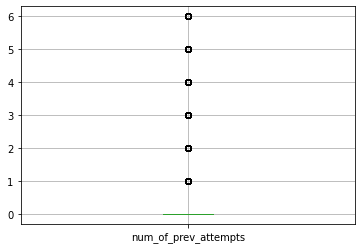

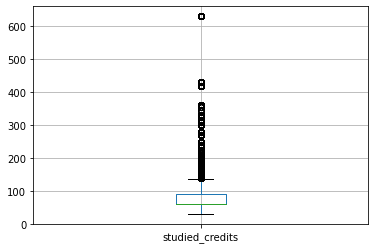

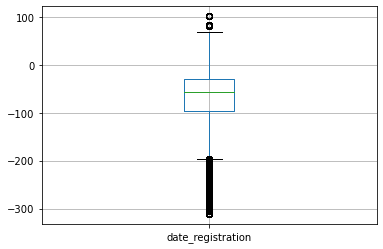

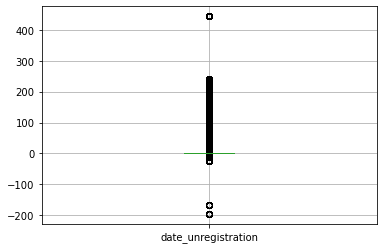

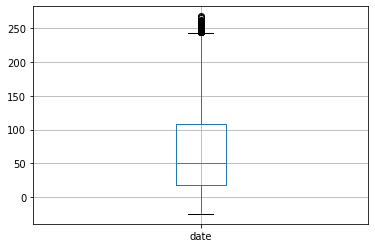

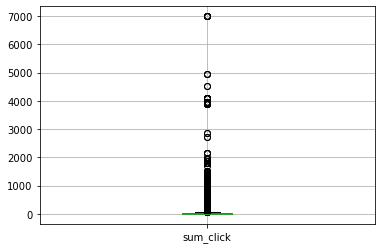

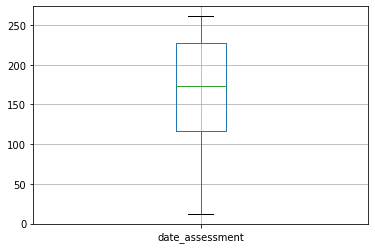

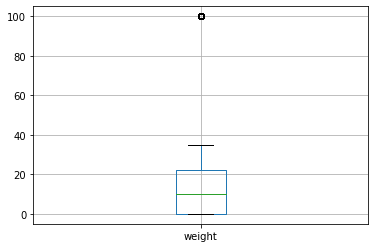

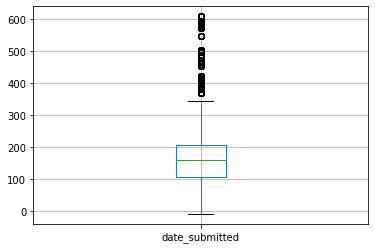

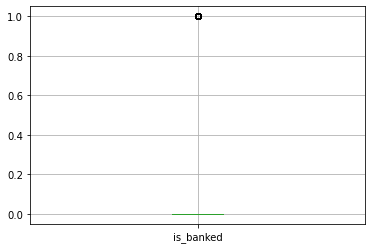

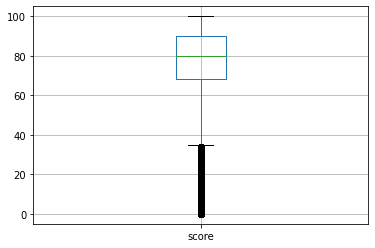

In [42]:
#boxplots of all the numeric columns
for column in numeric:
    plt.figure()
    df.boxplot([column])

Removing outliers in the unregistered column

In [43]:
#another dataframe to load all the values to remove a few rows based on date_unregistered column
df_unregister = pd.DataFrame()
cols = ['date_unregistration','code_module','code_presentation']
for i in cols:
    df_unregister[i]=df[i]

In [46]:
#merging code_info and df_unregister
df_unregister = pd.merge(df_unregister,data2, on=['code_module','code_presentation'],how='inner')

In [47]:
df_unregister.head()

,date_unregistration,code_module,code_presentation,module_presentation_length
0,0,AAA,2013J,268
1,0,AAA,2013J,268
2,0,AAA,2013J,268
3,0,AAA,2013J,268
4,0,AAA,2013J,268


In [48]:
#obtaing the indices of the rows with date_unreg>=module_presentation length
ind = df_unregister[df_unregister['date_unregistration']>=df_unregister['module_presentation_length']].index.tolist()
#ind

In [49]:
#dropping all the obtained rows
df.drop(ind, axis='rows',inplace = True)

In [8]:
df.drop(['code_module','code_presentation','final_result'],
  axis='columns', inplace=True)

In [14]:
df.columns

Index(['gender', 'highest_education', 'age_band', 'num_of_prev_attempts',
       'studied_credits', 'disability', 'date_registration',
       'date_unregistration', 'date', 'sum_click', 'assessment_type',
       'date_assessment', 'weight', 'date_submitted', 'is_banked', 'score'],
      dtype='object')

In [15]:
df.shape

(8324172, 16)

Correlation for the numeric columns

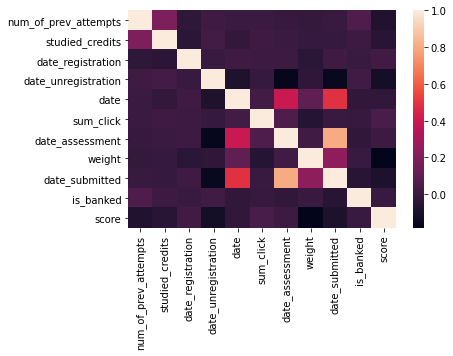

In [25]:
df_cont = pd.DataFrame()
for i in numeric:
    df_cont[i] = df[i]
corrdf = df_cont.corr(method ='pearson')
sns.heatmap(corrdf)

Checking if pca is needed

In [98]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
vif_data = pd.DataFrame()
vif_data["feature"] = df.columns
vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]

In [102]:
vif_data

,feature,VIF
0,num_of_prev_attempts,1.141196
1,studied_credits,2.781218
2,date_registration,21.083515
3,date_unregistration,21.641615
4,date,4.437395
5,sum_click,1.389575
6,date_assessment,19.818336
7,weight,1.705996
8,date_submitted,26.649363
9,is_banked,1.008912


In [125]:
#converting the obtained data to parquet file
df.to_parquet('preprocessed_parquet',index=False)